# IMDB Example

This example is based on an example from François Chollet's Deep Learning
with Python that was also made available in the
`3.5-classifying-movie-reviews.ipynb` notebook at

    https://github.com/fchollet/deep-learning-with-python-notebooks

In [1]:
!cd .. && pip install -e .

Obtaining file:///src/workspace/pybt
  Found existing installation: pybt 0.0.1
    Uninstalling pybt-0.0.1:
      Successfully uninstalled pybt-0.0.1
  Running setup.py develop for pybt


In [2]:
from keras import layers, models
from keras.datasets import imdb
from keras.layers import Dense
from keras.losses import binary_crossentropy
from keras.optimizers import RMSprop
from keras.utils import to_categorical

import numpy as np

from pybt import Population
from pybt.member import StopAfter

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))

    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.

    return results

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(
    num_words=10000)

x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

x_val = x_train[:10000]
partial_x_train = x_train[10000:]

y_val = y_train[:10000]
partial_y_train = y_train[10000:]

model = models.Sequential()
model.add(Dense(16, activation='relu', input_shape=(10000,)))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=RMSprop(lr=0.001),
              loss=binary_crossentropy,
              metrics=['accuracy'])

In [4]:
# Create a population with this model and train for 2 steps
pop = Population(model=model,
    stopping_criteria=StopAfter(epochs=20),
    step_args = {'epochs_per_step': 10,
                 'fit_args': {
                     'x': partial_x_train, 'y': partial_y_train,
                     'validation_data': (x_val, y_val),
                     'batch_size': 512}},
    eval_args = {'x': x_val, 'y': y_val})
model = pop.train()

10000/10000 [==============================] - 1s 102us/step
Train on 15000 samples, validate on 10000 samples
Epoch 1/10
15000/15000 [==============================] - 2s 131us/step - loss: 0.5085 - acc: 0.7815 - val_loss: 0.3797 - val_acc: 0.8690
Epoch 2/10
15000/15000 [==============================] - 2s 116us/step - loss: 0.3004 - acc: 0.9045 - val_loss: 0.3002 - val_acc: 0.8900
Epoch 3/10
15000/15000 [==============================] - 2s 113us/step - loss: 0.2179 - acc: 0.9281 - val_loss: 0.3081 - val_acc: 0.8717
Epoch 4/10
15000/15000 [==============================] - 2s 114us/step - loss: 0.1750 - acc: 0.9435 - val_loss: 0.2840 - val_acc: 0.8839
Epoch 5/10
15000/15000 [==============================] - 2s 116us/step - loss: 0.1426 - acc: 0.9545 - val_loss: 0.2848 - val_acc: 0.8866
Epoch 6/10
15000/15000 [==============================] - 2s 114us/step - loss: 0.1151 - acc: 0.9651 - val_loss: 0.3146 - val_acc: 0.8777
Epoch 7/10
15000/15000 [==============================] - 2s 

## Plotting population results

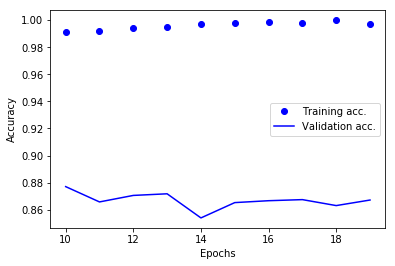

In [13]:
import matplotlib.pyplot as plt

last_member = pop.observations()[-1]
obs = last_member['observations'][-1]

plt.plot(obs['epochs'], obs['acc'], 'bo', label='Training acc.')
plt.plot(obs['epochs'], obs['val_acc'], 'b', label='Validation acc.')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

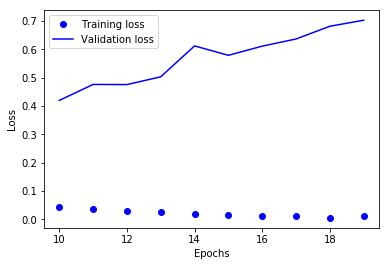

In [14]:
plt.plot(obs['epochs'], obs['loss'], 'bo', label='Training loss')
plt.plot(obs['epochs'], obs['val_loss'], 'b', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()